## Acessando base de treino e validação

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Definindo parâmetros
image_size = (256, 256)
batch_size = 16
seed_value = 42  # Seed para garantir mesma divisão

# Gerador de dados para treino com reescalamento
train_datagen = ImageDataGenerator(rescale=1./255)

# Gerador de treino (dados da pasta .train)
train_generator = train_datagen.flow_from_directory(
    'dataset/train',  # Pasta de treino
    target_size=image_size,  # Redimensiona para 256x256
    batch_size=batch_size,
    class_mode='categorical',  # Multi-classes
    seed=seed_value
)

# Gerador de validação (dados da pasta .validation)
validation_generator = train_datagen.flow_from_directory(
    'dataset/val',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    seed=seed_value
)


2024-10-04 01:56:36.043449: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-04 01:56:36.046332: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-04 01:56:36.056040: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-04 01:56:36.072436: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-04 01:56:36.077400: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-04 01:56:36.089356: I tensorflow/core/platform/cpu_feature_gu

Found 3477 images belonging to 13 classes.
Found 748 images belonging to 13 classes.


## Exemplificando as classes

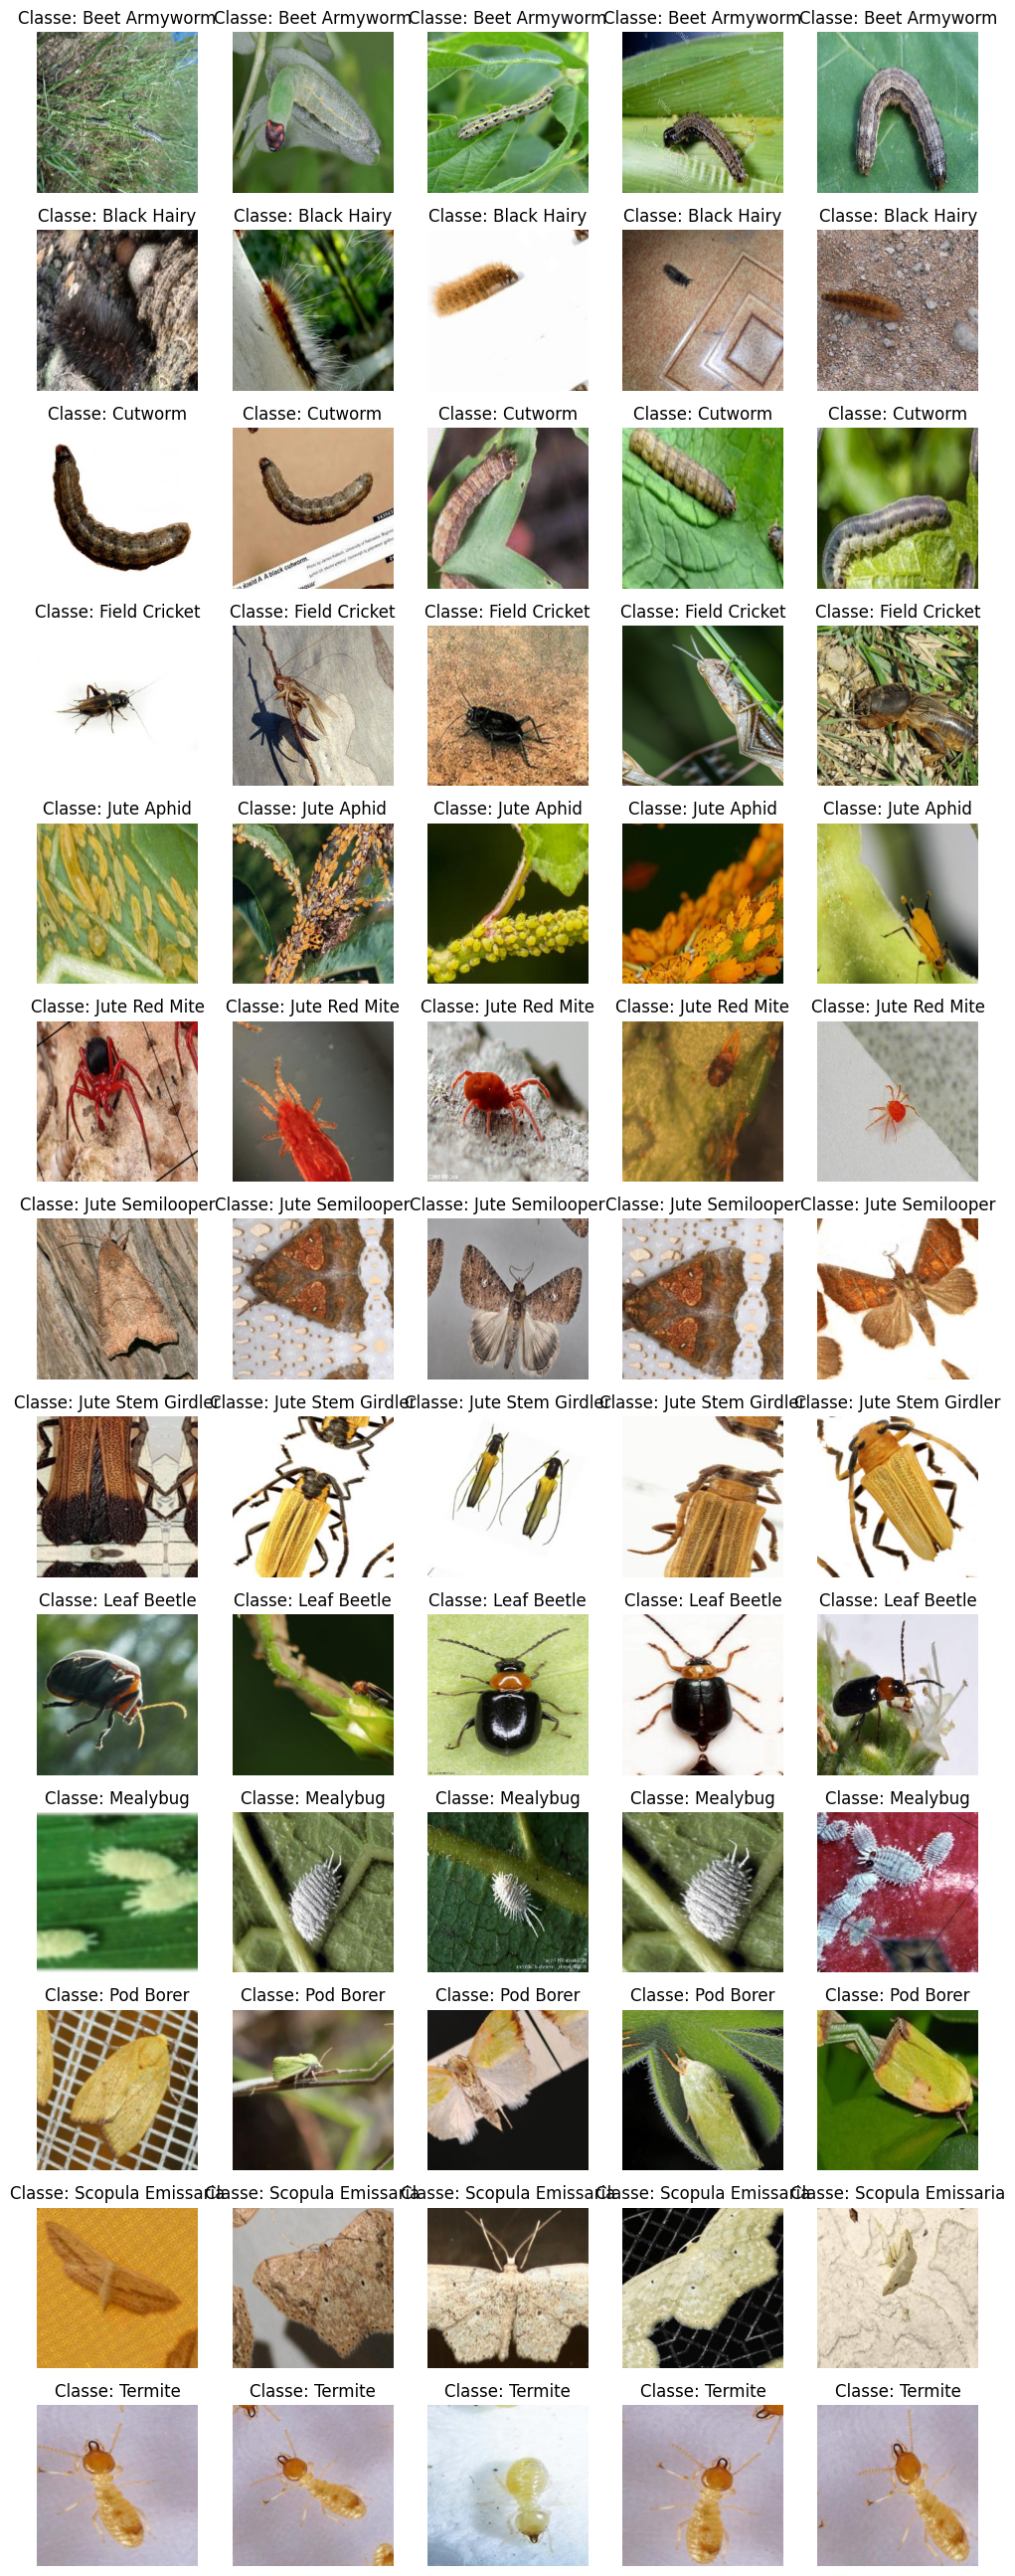

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Definir quantas imagens por classe você quer mostrar
num_images = 5

# Criar uma figura para plotar as imagens
plt.figure(figsize=(10, len(train_generator.class_indices) * 2))  # Ajuste a altura da figura

# Obter o número total de classes
class_labels = list(train_generator.class_indices.keys())
num_classes = len(class_labels)

# Inicializar um contador para plotar imagens
img_count = 0

# Iterar sobre cada classe
for class_index in range(num_classes):
    class_images = []
    
    # Pegar múltiplos batches para garantir que temos imagens suficientes
    while len(class_images) < num_images:
        x_batch, y_batch = next(train_generator)
        # Filtrar as imagens da classe atual
        class_images += [x_batch[i] for i in range(len(y_batch)) if np.argmax(y_batch[i]) == class_index]
    
    # Selecionar apenas as primeiras 'num_images' imagens
    class_images = class_images[:num_images]

    # Adicionar subplots para as imagens da classe
    for i in range(num_images):
        plt.subplot(num_classes, num_images, img_count + 1)
        plt.imshow(class_images[i])
        plt.title(f"Classe: {class_labels[class_index]}")
        plt.axis('off')
        img_count += 1

# Mostrar as imagens
plt.tight_layout()
plt.show()

## Transfer Learning e, posteriormente, Fine Tunning.

In [3]:

# Carregar o modelo VGG16 pré-treinado, sem as camadas finais
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar todas as camadas da base
for layer in base_model.layers:
    layer.trainable = False

# Criar o modelo
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))  # Regularização
model.add(Dense(len(train_generator.class_indices), activation='softmax'))  # Saída para múltiplas classes

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Configuração do early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Treinar o modelo
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=12,
    callbacks=[early_stopping],
    verbose=1
)

# Resumo do modelo
model.summary()

# Avaliação no conjunto de validação
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Acurácia de validação: {val_accuracy:.4f}')

# Descongelar as últimas 4 camadas da VGG16 para fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Compilar novamente o modelo com uma taxa de aprendizado menor
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Treinar o modelo com fine-tuning
history_fine_tuning = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Algumas épocas adicionais para fine-tuning
    callbacks=[early_stopping],
    verbose=1
)

# Avaliar o modelo no conjunto de validação após fine-tuning
val_loss_fine, val_accuracy_fine = model.evaluate(validation_generator)
print(f'Acurácia de validação (após fine-tuning): {val_accuracy_fine:.4f}')

# Gerador de teste
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'dataset/test',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Para garantir que as previsões e rótulos estejam alinhados
)

# Previsões no conjunto de teste
test_generator.reset()
steps = test_generator.samples // test_generator.batch_size + 1
predictions = model.predict(test_generator, steps=steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obter as classes verdadeiras
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calcular a acurácia no conjunto de teste
accuracy = accuracy_score(true_classes, predicted_classes)
print(f'Acurácia no conjunto de teste: {accuracy:.4f}')




2024-10-04 01:56:43.349852: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-10-04 01:56:43.349891: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:135] retrieving CUDA diagnostic information for host: rodrigo-Nitro
2024-10-04 01:56:43.349906: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:142] hostname: rodrigo-Nitro
2024-10-04 01:56:43.350046: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:166] libcuda reported version is: 535.183.1
2024-10-04 01:56:43.350085: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] kernel reported version is: 535.183.1
2024-10-04 01:56:43.350104: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:249] kernel version seems to match DSO: 535.183.1


Epoch 1/12


/home/digolira/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-10-04 01:56:45.100966: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2024-10-04 01:56:45.232350: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2024-10-04 01:56:45.622548: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2024-10-04 01:56:45.779467: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.


  1/218 ━━━━━━━━━━━━━━━━━━━━ 13:47 4s/step - accuracy: 0.1250 - loss: 3.1427

2024-10-04 01:56:47.682835: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.


218/218 ━━━━━━━━━━━━━━━━━━━━ 728s 3s/step - accuracy: 0.3198 - loss: 3.0217 - val_accuracy: 0.7045 - val_loss: 1.0536
Epoch 2/12
218/218 ━━━━━━━━━━━━━━━━━━━━ 758s 3s/step - accuracy: 0.6878 - loss: 0.9592 - val_accuracy: 0.8155 - val_loss: 0.7123
Epoch 3/12
218/218 ━━━━━━━━━━━━━━━━━━━━ 755s 3s/step - accuracy: 0.7702 - loss: 0.6835 - val_accuracy: 0.8596 - val_loss: 0.4931
Epoch 4/12
218/218 ━━━━━━━━━━━━━━━━━━━━ 755s 3s/step - accuracy: 0.8545 - loss: 0.4280 - val_accuracy: 0.8623 - val_loss: 0.4631
Epoch 5/12
218/218 ━━━━━━━━━━━━━━━━━━━━ 755s 3s/step - accuracy: 0.8734 - loss: 0.3759 - val_accuracy: 0.8783 - val_loss: 0.3952
Epoch 6/12
218/218 ━━━━━━━━━━━━━━━━━━━━ 756s 3s/step - accuracy: 0.8987 - loss: 0.3086 - val_accuracy: 0.8850 - val_loss: 0.3678
Epoch 7/12
218/218 ━━━━━━━━━━━━━━━━━━━━ 755s 3s/step - accuracy: 0.9081 - loss: 0.2590 - val_accuracy: 0.8663 - val_loss: 0.4248
Epoch 8/12
218/218 ━━━━━━━━━━━━━━━━━━━━ 755s 3s/step - accuracy: 0.9210 - loss: 0.2333 - val_accuracy: 0.871

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         3,341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,891,305 (152.17 MB)

 Trainable params: 8,392,205 (32.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 16,784,412 (64.03 MB)

47/47 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.8875 - loss: 0.3682
Acurácia de validação: 0.8850
Epoch 1/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 874s 4s/step - accuracy: 0.9319 - loss: 0.1999 - val_accuracy: 0.9104 - val_loss: 0.2979
Epoch 2/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 874s 4s/step - accuracy: 0.9517 - loss: 0.1314 - val_accuracy: 0.9144 - val_loss: 0.2883
Epoch 3/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 874s 4s/step - accuracy: 0.9468 - loss: 0.1482 - val_accuracy: 0.9158 - val_loss: 0.2764
Epoch 4/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 874s 4s/step - accuracy: 0.9587 - loss: 0.1244 - val_accuracy: 0.9238 - val_loss: 0.2613
Epoch 5/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 874s 4s/step - accuracy: 0.9633 - loss: 0.1022 - val_accuracy: 0.9251 - val_loss: 0.2636
Epoch 6/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 873s 4s/step - accuracy: 0.9554 - loss: 0.1216 - val_accuracy: 0.9318 - val_loss: 0.2234
Epoch 7/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 873s 4s/step - accuracy: 0.9687 - loss: 0.0980 - val_accuracy: 0.9305 - val_loss: 

## Matriz de Confusão (normalizada e absoluta) e gráfico acurácia perda

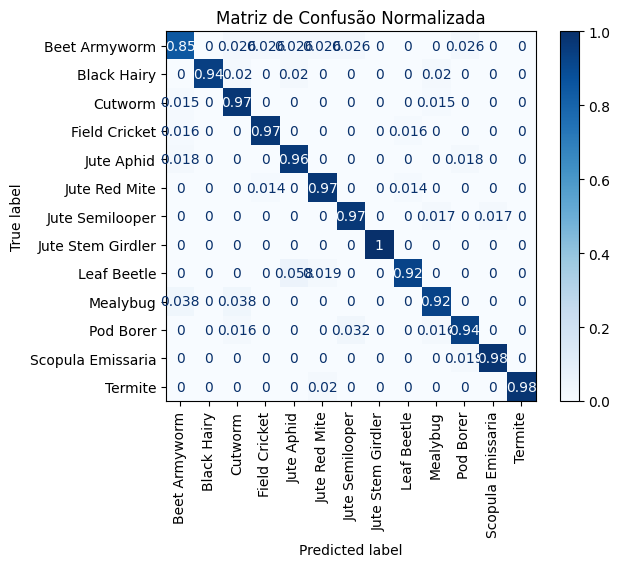

In [4]:
# Calculando a matriz de confusão com normalização
cm = confusion_matrix(true_classes, predicted_classes, normalize='true')

# Criando a visualização da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Matriz de Confusão Normalizada')
plt.show()

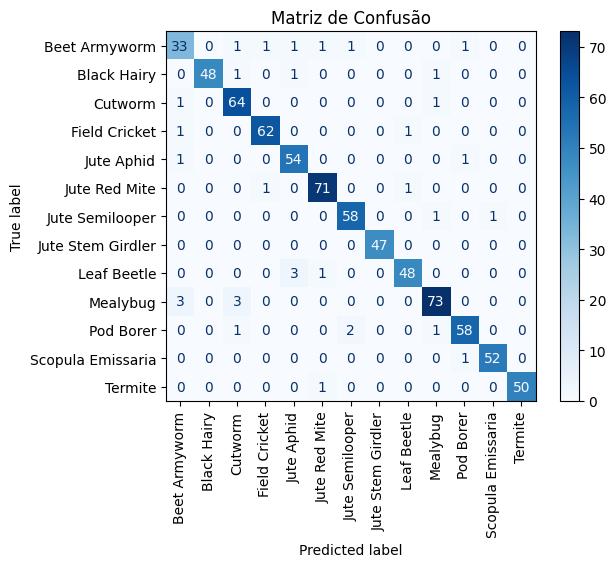

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Calculando a matriz de confusão sem normalização
cm = confusion_matrix(true_classes, predicted_classes)

# Criando a visualização da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')

plt.title('Matriz de Confusão')
plt.show()

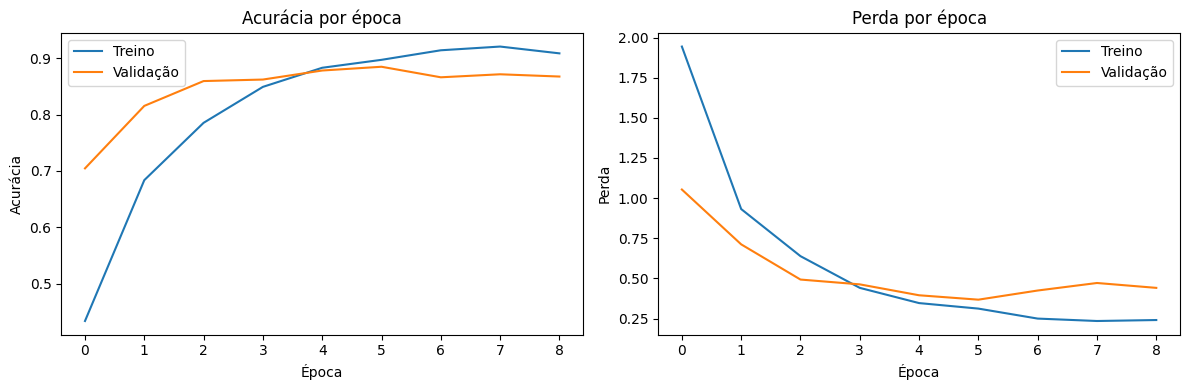

In [6]:
# Plotar o histórico de acurácia e perda
plt.figure(figsize=(12, 4))

# Gráfico da acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia por época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

# Gráfico da perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda por época')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score

# Calcular as métricas
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')

print(f"Acurácia: {accuracy:.3f}")
print(f"Precisão: {precision:.3f}")
print(f"Sensibilidade (Recall): {recall:.3f}")

Acurácia: 0.954
Precisão: 0.954
Sensibilidade (Recall): 0.954
